# Behavior Analysis: Kinematx

Press SHIFT + ENTER to run code

### USER INPUT!

In [29]:
## Define project
project_name = ''

# Of the groups listed in meta.py, list * ONE * as selected_group below.
selected_group = ''

# List out * ANY/ALL * conditions, see meta.py to see how you previously defined it for your project
selected_conditions = ['', '']

# Select bodypart of interest
bp_selects = "genitalia"

# 'nose', 'mouth', 'l_forepaw', 'l_forepaw_digit', 'r_forepaw', 'r_forepaw_digit', 'l_hindpaw', 'l_hindpaw_digit1', 'l_hindpaw_digit2', 'l_hindpaw_digit3', 'l_hindpaw_digit4', 'l_hindpaw_digit5', 'r_hindpaw', 'r_hindpaw_digit1', 'r_hindpaw_digit2', 'r_hindpaw_digit3', 'r_hindpaw_digit4', 'r_hindpaw_digit5', 'genitalia', 'tail_base'

### Main Code: Calculate + Figure Average Displacement of Bodypart Across Behavior

/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

CSV saved to ../processed_dataset/bla_sni_opto_inhibit/figures/behavior_kinematx/avg_displacement_conditions_SNI_genitalia.csv


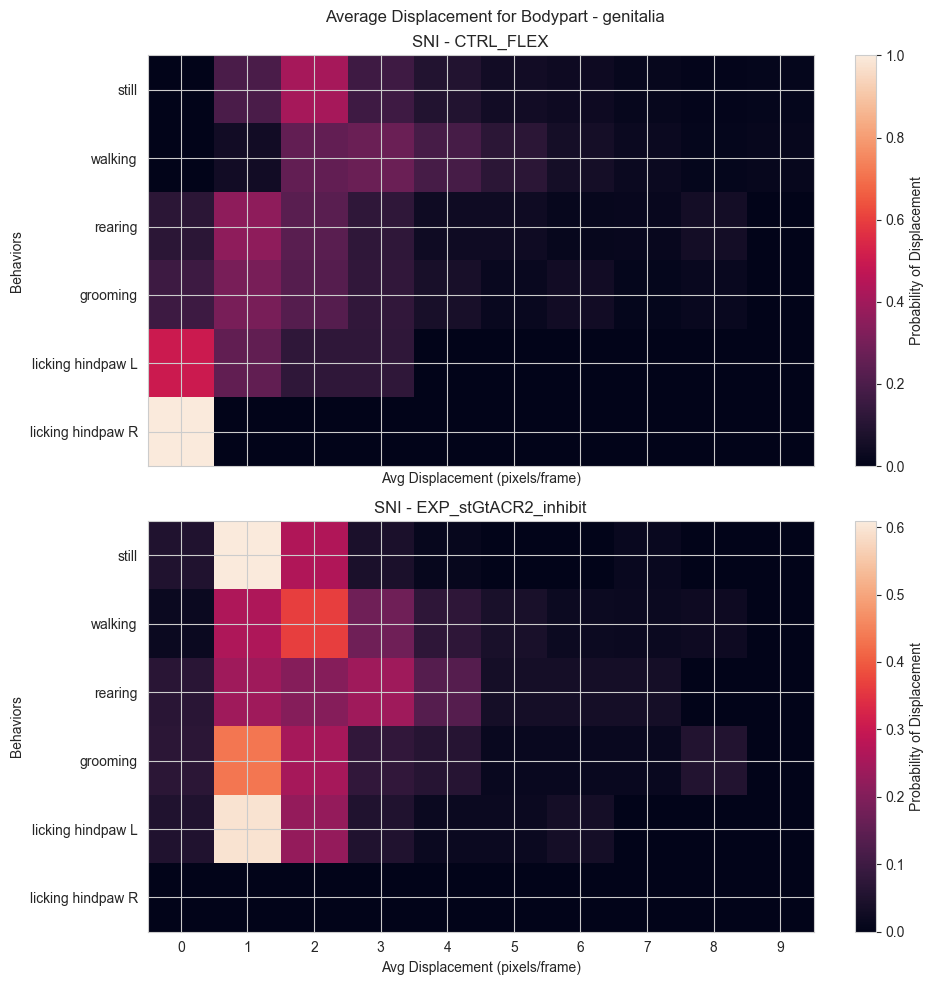

In [28]:
###### RUN DEPENDENCIES ######
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import os
import sys
if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))
from utils.classification import load_model, load_features, load_data, weighted_smoothing, load_behaviors
from utils.meta import *
from utils.feature_utils import get_avg_kinematics
from tqdm import notebook
import pickle
import os
import pandas as pd
import umap
from sklearn.preprocessing import LabelEncoder
import warnings

###### Load Model, Pose, Features, and Behaviors ######
model_path = '../model/model.pkl'
model = load_model(model_path)
data_path = f"../processed_dataset/{project_name}/raw_data_{project_name}.pkl"
poses = load_data(data_path)
features_path = f"../processed_dataset/{project_name}/binned_features_{project_name}.pkl"
features = load_features(features_path)
behaviors = load_behaviors(f"../processed_dataset/{project_name}/behaviors_{project_name}.pkl")

###### Define the directory path ######
directory_path = f"../processed_dataset/{project_name}/figures/behavior_kinematx/per_file_avg_displacement"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    
###### Analysis Code ######
movement_by_condition = {}

for selected_condition in selected_conditions:
    all_files_bout_disp = {}  

    files_dict = behaviors[selected_group][selected_condition]
    for file_key in files_dict.keys():
        _, _, _, bout_disp_dict, _, _ = get_avg_kinematics(
            files_dict[file_key],
            poses[selected_group][selected_condition][file_key],
            keypoints.index(bp_selects),
            framerate=60
        )

        for beh in bout_disp_dict:
            bout_disp_dict[beh] = np.asarray(bout_disp_dict[beh])

        all_files_bout_disp[file_key] = bout_disp_dict

        per_behavior_max = [
            np.percentile(arr, 95)
            for arr in bout_disp_dict.values()
            if arr.ndim == 1 and arr.size > 10
        ]
        max_all_file = np.max(per_behavior_max) if per_behavior_max else 1.0

        movement_n_bins = 10
        bin_edges_file = np.linspace(0, max_all_file, movement_n_bins + 1)

        perfile_avg_rows = []
        for beh in behavior_names:
            arr = bout_disp_dict.get(beh, np.array([]))
            if arr.size > 0:
                avg_disp = float(np.mean(arr))
            else:
                avg_disp = 0.0
            perfile_avg_rows.append({
                'File': file_key,
                'Behavior': beh,
                'AvgDisplacement': avg_disp
            })

        df_perfile_avg = pd.DataFrame(perfile_avg_rows)
        perfile_avg_path = os.path.join(
            perfile_avg_dir,
            f"{selected_group}_{selected_condition}_{file_key}_avg_displacement.csv"
        )
        # ensure directory exists
        os.makedirs(os.path.dirname(perfile_avg_path), exist_ok=True)
        df_perfile_avg.to_csv(perfile_avg_path, index=False)
        print(f"Saved per‐file average displacement: {perfile_avg_path}")

    behavioral_sums = {}
    for beh in behavior_names:
        concatenated = []
        for file_key, disp_dict in all_files_bout_disp.items():
            arr = disp_dict.get(beh, np.array([]))
            if arr.ndim == 1 and arr.size > 0:
                concatenated.append(arr)
        if concatenated:
            behavioral_sums[beh] = np.hstack(concatenated)
        else:
            behavioral_sums[beh] = np.array([])

    # Computing descriptive statistics across all files
    desc_rows = []
    for beh, arr in behavioral_sums.items():
        if arr.ndim == 1 and arr.size > 0:
            mean_disp   = float(np.mean(arr))
            median_disp = float(np.median(arr))
            std_disp    = float(np.std(arr))
            count_n     = int(arr.size)
        else:
            mean_disp = median_disp = std_disp = 0.0
            count_n = 0
        desc_rows.append({
            'Condition': selected_condition,
            'Behavior': beh,
            'MeanDisplacement': mean_disp,
            'MedianDisplacement': median_disp,
            'StdDisplacement': std_disp,
            'Count': count_n
        })
    df_desc = pd.DataFrame(desc_rows)
    desc_csv_path = os.path.join(
        base_output_dir,
        f"behavior-kinematx_descriptive_stats_{selected_group}_{selected_condition}_{bp_selects}.csv"
    )
    df_desc.to_csv(desc_csv_path, index=False)
    print(f"Saved descriptive stats CSV: {desc_csv_path}")

    global_max_perb = [
        np.percentile(arr, 95)
        for arr in behavioral_sums.values()
        if arr.ndim == 1 and arr.size > 10
    ]
    max_all = np.max(global_max_perb) if global_max_perb else 1.0

    movement_n_bins = 10
    global_bin_edges = np.linspace(0, max_all, movement_n_bins + 1)
    global_bin_centers = (global_bin_edges[:-1] + global_bin_edges[1:]) / 2
    pre_alloc_movement = np.zeros((len(behavior_names), movement_n_bins))
    label_encoder = LabelEncoder()

    for b, beh in enumerate(behavior_names):
        arr = behavioral_sums.get(beh, np.array([]))
        if arr.ndim != 1 or arr.size == 0:
            counts = np.zeros(movement_n_bins)
        else:
            df_temp = pd.DataFrame({'bp_movement': arr})
            cats = pd.cut(df_temp['bp_movement'],
                          bins=global_bin_edges,
                          labels=False,
                          include_lowest=True)
            counts, _ = np.histogram(cats, bins=np.arange(-0.5, movement_n_bins + 0.5, 1))
        pre_alloc_movement[b, :] = counts

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        row_sums = pre_alloc_movement.sum(axis=1)
        movement_by_behav = pre_alloc_movement / row_sums[:, np.newaxis]

    movement_by_condition[selected_condition] = movement_by_behav

for condition, movement_data in movement_by_condition.items():
    per_condition_rows = []
    for beh_idx, beh in enumerate(behavior_names):
        for bin_idx, prob in enumerate(movement_data[beh_idx]):
            per_condition_rows.append({
                'Condition': condition,
                'Behavior': beh,
                'Bin': bin_idx,
                'BinCenter': float(global_bin_centers[bin_idx]),
                'Probability': float(prob)
            })
    df_one = pd.DataFrame(per_condition_rows)
    csv_path_one = os.path.join(
        base_output_dir,
        f"plot_avg_displacement_{condition}_{selected_group}_{bp_selects}.csv"
    )
    df_one.to_csv(csv_path_one, index=False)
    print(f"Saved CSV for {condition}: {csv_path_one}")

n_bins = movement_n_bins  # 10
n_behaviors = len(behavior_names)
n_conditions = len(selected_conditions)

fig, axes = plt.subplots(
    nrows=n_conditions,
    ncols=1,
    figsize=(10, 4 * n_conditions),
    sharex=True
)
if n_conditions == 1:
    axes = [axes]

for i, cond in enumerate(selected_conditions):
    ax = axes[i]
    heatmap = ax.imshow(
        movement_by_condition[cond],
        aspect='auto',
        cmap='viridis'
    )
    ax.set_title(f'{selected_group} – {cond}')
    ax.set_ylabel('Behaviors')
    ax.set_yticks(np.arange(n_behaviors))
    ax.set_yticklabels(behavior_names)
    ax.set_xlabel('Displacement Bin Center (pixels/frame)')
    fig.colorbar(heatmap, ax=ax, label='Probability')

plt.suptitle(f'Average Displacement Distribution for Bodypart: {bp_selects}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

fig_path = os.path.join(
    base_output_dir,
    f"avg_displacement_conditions_{selected_group}_{bp_selects}.svg"
)
plt.savefig(fig_path, format='svg', dpi=600, bbox_inches='tight')
print(f"Saved heatmap figure: {fig_path}")

plt.show()

### Repeat code for * alternative * group to be analyzed... otherwise...    

# ANALYSIS COMPLETE!